#### ARMA Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

## ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from ipywidgets import IntProgress
from tqdm import tqdm_notebook

from itertools import product

In [3]:
plt.rcParams['figure.figsize'] = (10, 8)

##### Simulate ARMA(1,1)

In [4]:
ar1 = np.array([1, 0.33])
ma1 =  np.array([1, 0.9])

In [5]:
ARMA_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

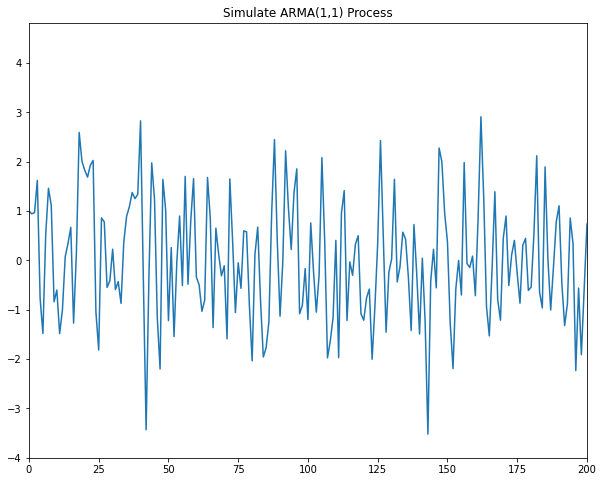

In [6]:
plt.plot(ARMA_1)
plt.title('Simulate ARMA(1,1) Process')
plt.xlim([0, 200])
plt.show()

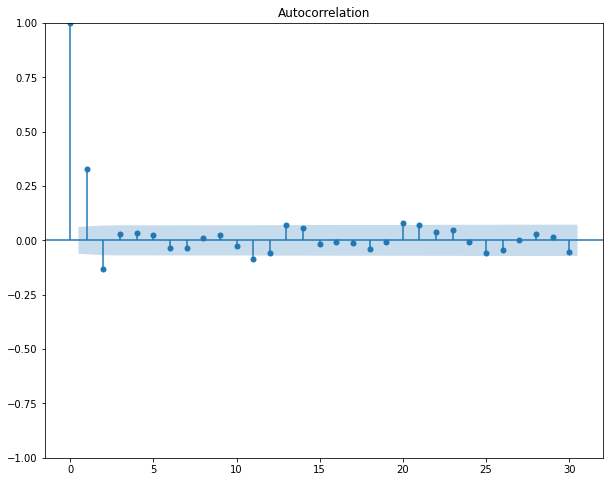

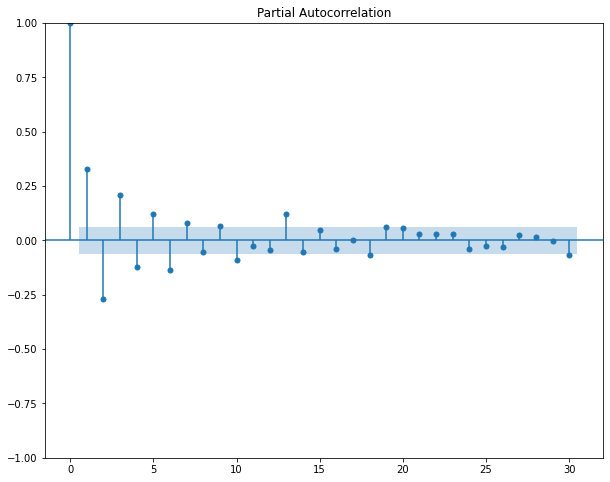

In [7]:
plot_acf(ARMA_1)
plot_pacf(ARMA_1)
plt.show()

##### ARMA(2,2) Process

In [8]:
ar2 = np.array([1, 0.33, 0.5])
ma2 =  np.array([1, 0.9, 0.3])

ARMA_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

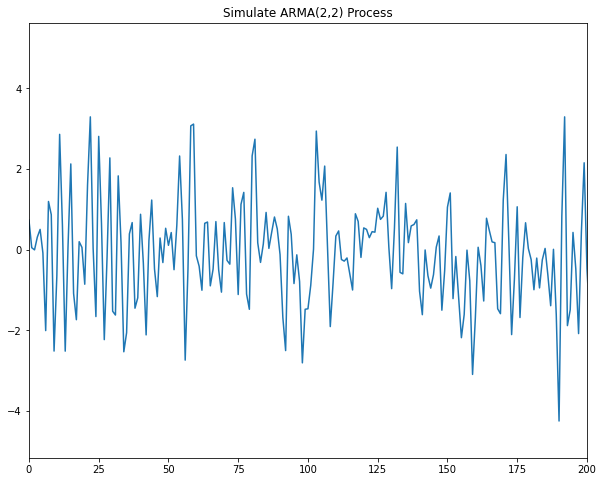

In [9]:
plt.plot(ARMA_2)
plt.title('Simulate ARMA(2,2) Process')
plt.xlim([0, 200])
plt.show()

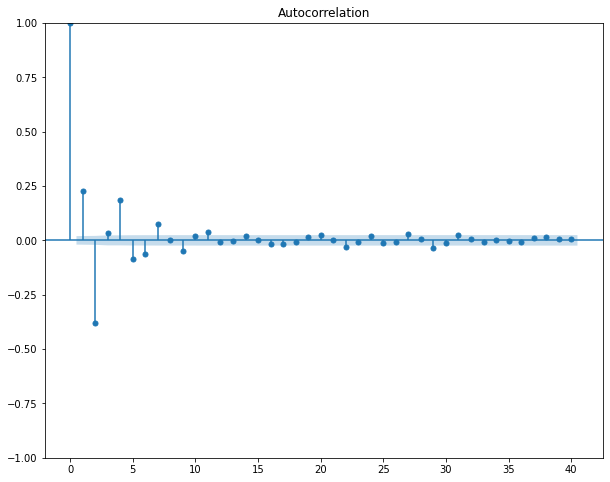

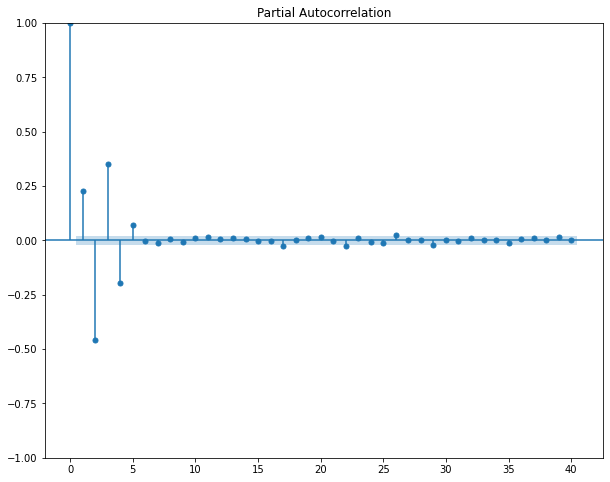

In [10]:
plot_acf(ARMA_2)
plot_pacf(ARMA_2)
plt.show()

#### ARIMA

In [11]:
df = pd.read_csv('./data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [12]:
fig = px.line(df, x=df.date, y=df.data, width=800, height=400, color_discrete_sequence=['#fcba03'],
                 title='Quaterly EPS for J&J', labels= {'date': 'Year','data':'EPS($)'})
fig.show()

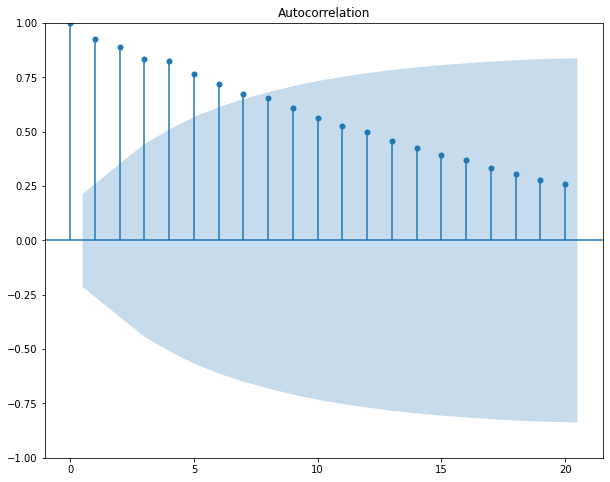

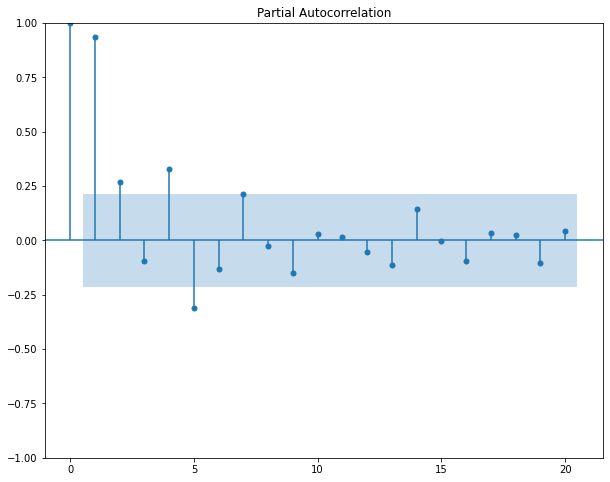

In [13]:
plot_acf(df['data'])
plot_pacf(df['data'])
plt.show()

In [14]:
## Make data stationarity using Log difference
df['data_tr_1'] = np.log(df['data'])
df['data_tr_1'] = df['data_tr_1'].diff()

df.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


In [15]:
fig = px.line(df, x=df.date, y=df.data_tr_1, width=800, height=400, color_discrete_sequence=['#fcba03'],
                 title='Log Difference of Quaterly EPS for J&J', labels= {'date': 'Year','data_tr_1':'EPS($)'})
fig.show()

In [16]:
ad_fuller_result = adfuller(df['data_tr_1'][1:])
print(f"ADF Statistics: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistics: -4.317043945811843
p-value: 0.00041497314044405543


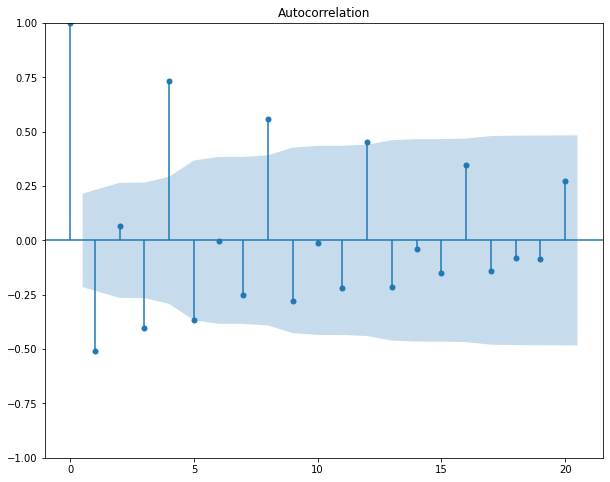

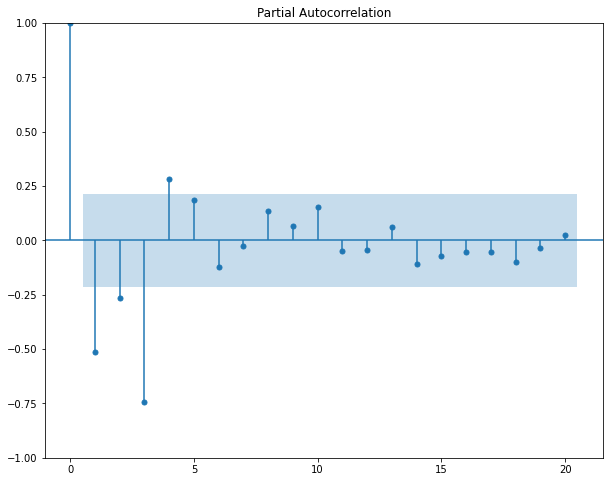

In [17]:
plot_acf(df['data_tr_1'][1:])
plot_pacf(df['data_tr_1'][1:])
plt.show()

By looking at the ACF and PACF we cannot say the order of the data.

In [18]:
def optimize_ARIMA(endog, order_list):
    """
       Returns the df with parameters and corresponding AIC

       order_list - list with (p,d,q) tuples
       endog - the observed variables
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results, columns=['(p,d,q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [19]:
ps = range(0, 8, 1) ## AR
d = 1
qs = range(0, 8, 1) ## MA

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

order_list[:10]


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [20]:
result_df = optimize_ARIMA(df['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: 

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.740410
1,"(4, 1, 6)",115.859337
2,"(7, 1, 1)",116.053260
3,"(5, 1, 3)",116.536200
4,"(5, 1, 4)",117.242653
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497399
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [24]:
best_model = SARIMAX(df['data'], order=(6,1,3), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.870
Date:                Sun, 12 Jun 2022   AIC                            115.740
Time:                        13:55:17   BIC                            139.929
Sample:                             0   HQIC                           125.458
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4239      0.120    -11.821      0.000      -1.660      -1.188
ar.L2         -0.7074      0.144     -4.899      0.000      -0.990      -0.424
ar.L3          0.0509      0.062      0.820      0.4

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The 3rd Coeff of AR process ar.L3 and second coeff of order ma.L2 seems to be not significant as p-value as greater than 0.05

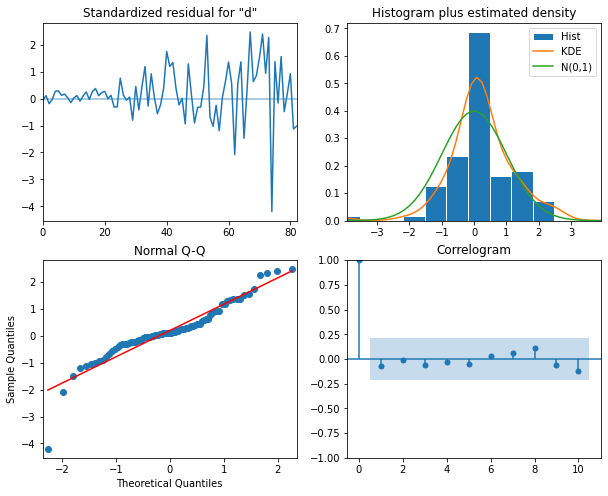

In [25]:
res.plot_diagnostics()
plt.show()

The residuals are normal gaussian as the QQ plot the data is in the straight line<br>
The correlogram shows stationarity <br>
The model is good<br>

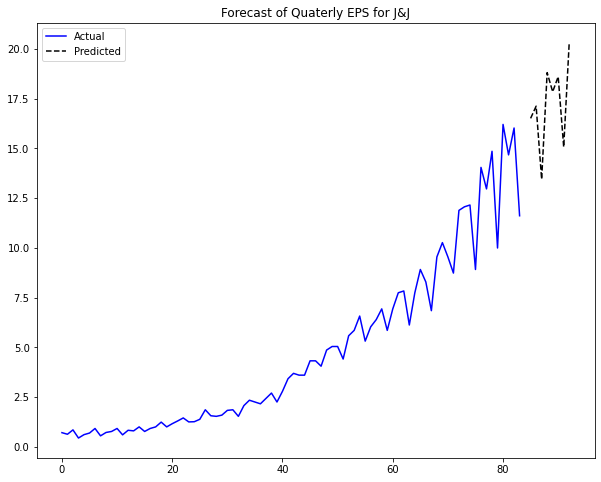

In [33]:
## Forecasting

n_forecast = 8
predict = res.get_prediction(end= best_model.nobs + n_forecast) # nobs - no of observations
idx = np.arange(len(predict.predicted_mean))


fig,ax = plt.subplots()
ax.plot(df['data'], color='blue', label='Actual')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label='Predicted')


ax.set_title("Forecast of Quaterly EPS for J&J")
plt.legend()
plt.show()

In [34]:
# Calculating mean_square error based on the predicted values

df['model'] = predict.predicted_mean
df.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.678018
3,1960-10-01,0.44,-0.658462,0.721612
4,1961-01-01,0.61,0.326684,0.650903
5,1961-04-02,0.69,0.123233,0.529301
6,1961-07-02,0.92,0.287682,0.787310
7,1961-10-01,0.55,-0.514455,0.493523
8,1962-01-01,0.72,0.269333,0.645599
9,1962-04-02,0.77,0.067139,0.754954


In [35]:
mse = mean_squared_error(df['data'], df['model'])

print(f"MSE: {mse}")

MSE: 0.16336062116315755
